In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
from skbio.stats.composition import ilr
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
from matplotlib import rcParams
sns.set()
sns.set(font_scale=1.5)

In [7]:
globalSpeciesAll = pd.read_csv("./DataFiles/Dataframes/allCohorts_allSpecies.csv")
GoodSampleNames = list(globalSpeciesAll['SampleName'])
print(len(GoodSampleNames))

606


In [8]:
print(len(globalSpeciesAll[globalSpeciesAll['Cohort']=='European'].set_index("SampleName")))

120


In [9]:
print(len(set(list(globalSpeciesAll[globalSpeciesAll['Cohort']=='European'].set_index("SampleName").index))))

120


In [10]:
globalSpeciesAll2 = globalSpeciesAll.set_index("SampleName")
americanSampleList = list(globalSpeciesAll2[globalSpeciesAll2['Cohort']=='American'].index)
print(len(americanSampleList))
europeanSampleList = list(globalSpeciesAll2[globalSpeciesAll2['Cohort']=='European'].index)
print(len(europeanSampleList))
indianSampleList = list(globalSpeciesAll2[globalSpeciesAll2['Cohort']=='Indian'].index)
print(len(indianSampleList))
japaneseSampleList = list(globalSpeciesAll2[globalSpeciesAll2['Cohort']=='Japanese'].index)
print(len(japaneseSampleList))
print(len(japaneseSampleList)+len(indianSampleList)+len(europeanSampleList)+len(americanSampleList))

202
120
106
178
606


## Import Cohort base pair dict or csvs

In [11]:
IndianBaseDF = pd.read_csv("./DataFiles/CohortInformation/IndianCohortBasePairCount.csv").set_index("SampleName")
IndianBaseDF['CleanName']='temp'
for i in IndianBaseDF.index:
    IndianBaseDF.at[i,'CleanName'] = i.split("_")[0]
IndianBaseDF2 = IndianBaseDF.reset_index().set_index("CleanName").drop(columns=['SampleName']).copy()
IndianBaseDF2.index.name='SampleName'
IndianBaseDF3 = IndianBaseDF2.loc[indianSampleList].copy()
IndianBaseDF3.head()

,Total_Base_Pairs
SampleName,
SRR5898908,645355043
SRR5898909,370680791
SRR5898910,1019643047
SRR5898911,544385107
SRR5898912,499566024


In [12]:
print(len(IndianBaseDF3))

106


In [13]:
IndianBaseDF3['Total_Base_Pairs'].sum()

60303176660

In [14]:
##############################################################

In [15]:
JapaneseBaseDF = pd.read_csv("./DataFiles/CohortInformation/JapaneseCohortBasePairCount.csv").set_index("SampleName")
JapaneseBaseDF.head()
JapaneseBaseDF['CleanName']='temp'
for i in JapaneseBaseDF.index:
    JapaneseBaseDF.at[i,'CleanName'] = i.split(".")[0]
JapaneseBaseDF2 = JapaneseBaseDF.reset_index().set_index("CleanName").drop(columns=['SampleName']).copy()
JapaneseBaseDF2.index.name='SampleName'
JapaneseBaseDF2.head()

,Total_Base_Pairs
SampleName,
DRR171610,3961598518
DRR171608,3546867040
DRR171613,3802003047
DRR127524,5597591218
DRR171616,3874132490


In [16]:
print(len(JapaneseBaseDF2))

178


In [17]:
JapaneseBaseDF['Total_Base_Pairs'].sum()

600931040883

In [18]:
##################################################################

In [19]:
import json

with open("./DataFiles/CohortInformation/American.json", "r") as read_file:
    americanBaseDict = json.load(read_file)

americanBaseDictClean = {'SampleName':[],'Total_Base_Pairs':[]}

i=0
for x in list(americanBaseDict['SampleName']):
    try:
        if 'sub' in str(x):
            i+=1
            continue
        else:
            if x.split(".")[0] in americanSampleList:
                americanBaseDictClean['SampleName'].append(x)
                americanBaseDictClean['Total_Base_Pairs'].append(americanBaseDict['Total_Base_Pairs'][i])
                i+=1
                continue
    except:
        continue

In [20]:
americanBaseDF = pd.DataFrame(data=americanBaseDictClean).set_index("SampleName")
americanBaseDF.head()
print(len(americanBaseDF))

202


In [21]:
americanBaseDF['Total_Base_Pairs'].sum()

1019150376426

In [22]:
##############################################################################################

In [24]:
import json
europeanBaseDictClean = {'SampleName':[],'Total_Base_Pairs':[]}
with open("./DataFiles/CohortInformation/EuropeanFileReadTotal.txt", "r") as read_file2:
    for line in read_file2:
        if '.mt.out' in line:
            europeanBaseDictClean['SampleName'].append(line.split(".")[0])
        else:
            europeanBaseDictClean['Total_Base_Pairs'].append(int(line.strip()))
EuropeantempDF = pd.DataFrame(data=europeanBaseDictClean).set_index('SampleName')
EuropeantempDF2 = EuropeantempDF.loc[europeanSampleList].copy()
EuropeantempDF2.head()

,Total_Base_Pairs
SampleName,
ERR011089,4189554
ERR011090,11165128
ERR011091,7927924
ERR011092,4477651
ERR011093,10856301


In [25]:
EuropeantempDF2['Total_Base_Pairs'].sum()

621870696

In [26]:
print(len(EuropeantempDF2))

120


In [27]:
TotalBaseCount = int(EuropeantempDF2['Total_Base_Pairs'].sum())+int(americanBaseDF['Total_Base_Pairs'].sum())+int(JapaneseBaseDF['Total_Base_Pairs'].sum())+int(IndianBaseDF3['Total_Base_Pairs'].sum())
TotalBaseCount

1681006464665

In [28]:
print(len(EuropeantempDF2.index) + len(americanBaseDF.index) + len(JapaneseBaseDF.index) + len(IndianBaseDF3.index))

606


## Load Small Sample Information DataFrame

In [29]:
allCohortInfoDF = pd.read_csv("./DataFiles/CohortInformation/SampleMappingInformation.csv").set_index("SampleName")
HealthyCohortDF = allCohortInfoDF[(allCohortInfoDF['Cohort']!='nonIBD') & (allCohortInfoDF['Cohort']!='IBD')&(allCohortInfoDF['Cohort']!='CRC') &(allCohortInfoDF['Cohort']!='Chinese')].copy()
HealthyCohortDF.head()

,Cohort,Total_Reads,Mapped,Fraction_Mapped
SampleName,,,,
SRS019068,American,146440506.0,90989903.0,0.621344
SRS015431,American,145342910.0,91257053.0,0.627874
SRS147766,American,124128156.0,77035032.0,0.620609
SRS103987,American,116236100.0,71842871.0,0.618077
SRS143876,American,111457769.0,68106301.0,0.611050


## Average Read Length Per Sample

In [30]:
rlDictionary = {}
with open("./DataFiles/CohortInformation/allCohorts.txt") as rlFile:
    for line in rlFile:
        rlDictionary[line.split(".")[0].split("_R1")[0].split("_TR")[0].split(".")[0].strip()]=line.split("\t")[1].strip()
rlDictionary

{'SRS024132': '90',
 'SRS024265': '95',
 'SRS019582': '96',
 'SRS011061': '95',
 'SRS020233': '93',
 'SRS016517': '76',
 'SRS024331': '91',
 'SRS016753': '93',
 'SRS019601': '93',
 'SRS011084': '92',
 'SRS014979': '94',
 'SRS016954': '91',
 'SRS024075': '93',
 'SRS011134': '90',
 'SRS024435': '87',
 'SRS016989': '90',
 'SRS015264': '96',
 'SRS011239': '92',
 'SRS015578': '94',
 'SRS017103': '95',
 'SRS020328': '97',
 'SRS011271': '91',
 'SRS042284': '94',
 'SRS017191': '97',
 'SRS015369': '85',
 'SRS011302': '91',
 'SRS021484': '96',
 'SRS017247': '93',
 'SRS015431': '83',
 'SRS011405': '94',
 'SRS020869': '92',
 'SRS011452': '95',
 'SRS022609': '88',
 'SRS017307': '96',
 'SRS022137': '88',
 'SRS011529': '92',
 'SRS024388': '93',
 'SRS017433': '95',
 'SRS015663': '96',
 'SRS011586': '90',
 'SRS015794': '93',
 'SRS017521': '93',
 'SRS021948': '96',
 'SRS012273': '90',
 'SRS043701': '92',
 'SRS017701': '92',
 'SRS045528': '92',
 'SRS017821': '90',
 'SRS022071': '96',
 'SRS012902': '94',


## MetaData

In [31]:
GoodSampleNames = list(globalSpeciesAll['SampleName'])
globalmeta = pd.read_csv("./DataFiles/CohortInformation/TotalMetaDataFile.csv")
globalmeta

,Unnamed: 0,sampleid,username,studydayno,studydate,sample.week.day,dietdayno,diet.record.date,diet.week.day,gender,...,group,stage,brinkman index,alcohol,tumor location,sample,geo_loc_name,age group,diet,alias
0,MCT_f_0001,MCT.f.0001,MCTs01,1.0,1/31/17,Tuesday,0.0,1/30/17,Monday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MCT_f_0002,MCT.f.0002,MCTs01,2.0,2/1/17,Wednesday,1.0,1/31/17,Tuesday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MCT_f_0003,MCT.f.0003,MCTs01,3.0,2/2/17,Thursday,2.0,2/1/17,Wednesday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MCT_f_0004,MCT.f.0004,MCTs01,4.0,2/3/17,Friday,3.0,2/2/17,Thursday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MCT_f_0005,MCT.f.0005,MCTs01,5.0,2/4/17,Saturday,4.0,2/3/17,Friday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MCT_f_0006,MCT.f.0006,MCTs01,6.0,2/5/17,Sunday,5.0,2/4/17,Saturday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MCT_f_0007,MCT.f.0007,MCTs01,7.0,2/6/17,Monday,6.0,2/5/17,Sunday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MCT_f_0008,MCT.f.0008,MCTs01,8.0,2/7/17,Tuesday,7.0,2/6/17,Monday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MCT_f_0009,MCT.f.0009,MCTs01,9.0,2/8/17,Wednesday,8.0,2/7/17,Tuesday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MCT_f_0010,MCT.f.0010,MCTs01,10.0,2/9/17,Thursday,9.0,2/8/17,Wednesday,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
metaDF = globalmeta.set_index("Unnamed: 0").loc[GoodSampleNames][['gender','age']].copy()
metaDF['Cohort']=list(globalSpeciesAll['Cohort'])
metaDF.index.name='SampleName'
set(metaDF['gender'])
metaDF['Gender'] = 'temp'
for sample in metaDF.index:
    if (str(metaDF.at[sample, 'gender'])[0].lower()) == 'f':
        metaDF.at[sample,'Gender'] = 'Female'
    else:
        metaDF.at[sample,'Gender'] = 'Male'
metaDF.drop(columns=['gender'], inplace=True)
metaDF.head()

,age,Cohort,Gender
SampleName,,,
SRS011061,25,American,Female
SRS011084,25,American,Male
SRS011134,25,American,Male
SRS011239,25,American,Female
SRS011271,25,American,Male


In [33]:
tempDict = {'Cohort':[], 'Sex':[], 'Frequency':[]}

for cohort in list(set(metaDF['Cohort'])):
    
    
    tempDF = metaDF[metaDF['Cohort']==cohort].copy()
    
    for gender in list(set(metaDF['Gender'])):
        
        tempDict['Cohort'].append(cohort)
        tempDict['Sex'].append(gender)
        tempDict['Frequency'].append(len(tempDF[tempDF['Gender']==gender])/len(tempDF['Gender'].dropna()))
        
tempDF = pd.DataFrame(data=tempDict)
tempDF

,Cohort,Sex,Frequency
0,Indian,Female,0.500000
1,Indian,Male,0.500000
2,Japanese,Female,0.438202
3,Japanese,Male,0.561798
4,American,Female,0.470297
5,American,Male,0.529703
6,European,Female,0.658333
7,European,Male,0.341667


Text(0.5,1,'Subject Sex Frequency in Cohort Populations')

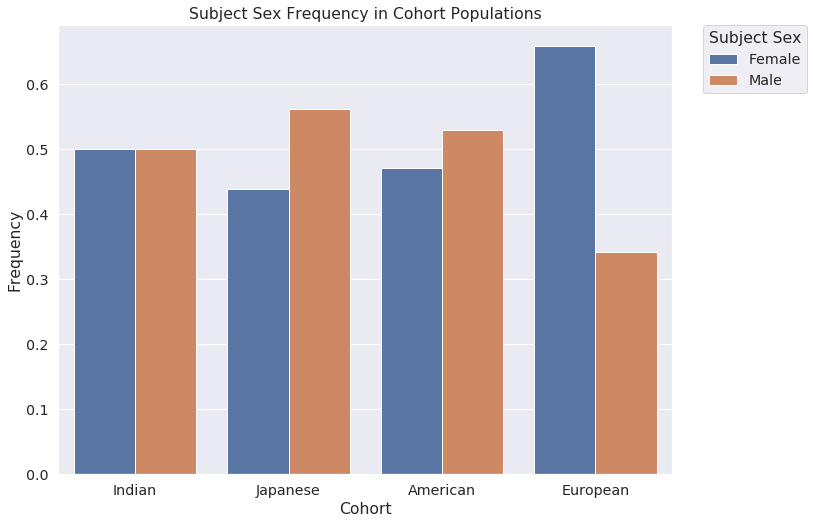

In [34]:
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11,8.27
sns.barplot(x="Cohort", y='Frequency',hue="Sex", data=tempDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Subject Sex')
plt.title("Subject Sex Frequency in Cohort Populations")

In [35]:
metaDF['Age'] = [int(float(x)) for x in metaDF['age']]
metaDF.head()
metaDF2 = metaDF.replace("American", np.nan).dropna().copy()
metaDF2.head()

,age,Cohort,Gender,Age
SampleName,,,,
SRR5898908,29,Indian,Female,29
SRR5898909,22,Indian,Female,22
SRR5898910,24,Indian,Male,24
SRR5898911,25,Indian,Female,25
SRR5898912,23,Indian,Female,23


Text(0.5,1,'Subject Age in Cohort Populations')

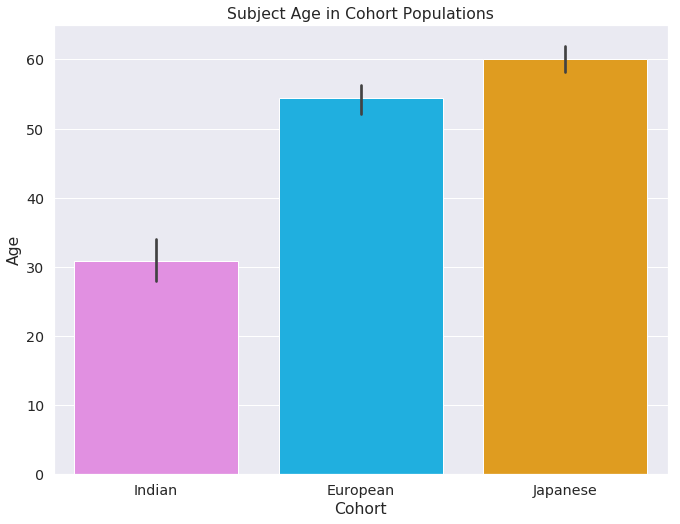

In [36]:
sns.set(font_scale=1.3)
palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

rcParams['figure.figsize'] = 11,8.27
sns.barplot(x="Cohort", y='Age', data=metaDF2, ci=95, palette=palette)
plt.title("Subject Age in Cohort Populations")